In [4]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import tifffile
from PIL import Image
import os
import numpy as np
import time
import re
from skimage import data, color
import scipy.ndimage as ndimage
import h5py
import scipy.io as spio
import sys
import seaborn
seaborn.set(font_scale=2)
seaborn.set_style('whitegrid')
clrs = seaborn.color_palette()
from multiprocessing.dummy import Pool 

sys.path.append('/home/yves/Documents/')
import twoptb as MP



In [2]:
animal_name = 'Road_Runner_GP'
HDF_File,file_path = MP.file_management.create_base_hdf(animal_ID=animal_name,file_loc='/media/yves/Storage 2/' )

File already exists if you proceed you will overwrite 
 are you sure you would like to proceed
type yes if you would like to proceed otherwise press enter
File not overwritten, returning handle to existing file


In [3]:
session_ID = '20160216'

In [7]:
HDF_File = MP.file_management.add_session_groups(file_handle = HDF_File,
                                                 session_ID=session_ID)

In [11]:
#directory containing all the directories containing all tiff files from that day
#baseDir = r'l:\Tonotopy_Mapping\Bernie-Tonemapping\\'
baseDir = r'/media/yves/Samuel/Raw/20160216/Area01/'


fs = os.listdir(baseDir) # all directories in that directory
file_Dirs = fs
#now use regex to filter which files we want to register
#file_Dirs = [re.findall(r'(.*Mapping_Area[0-9]{1,3})',name) for name in fs if re.findall(r'.*(Mapping_Area[0-9]{1,3})',name)!=[]]
file_Dirs

['(20160216_17_38_29)-_MouseOnWheelzoom2_tones1',
 '(20160216_17_48_00)-_MouseOnWheelzoom2_tones2',
 '(20160216_17_59_00)-_MouseOnWheelzoom2_tones3']

In [12]:
st = time.time()
MP.file_management.add_raw_series(baseDir=baseDir,
                                  file_Dirs=file_Dirs,
                                  HDF_File=HDF_File,
                                  session_ID=session_ID)

print time.time() - st

Load Data 0 Time: 114.468129873
Load HDF5 0 Time: 9.53674316406e-07
(20160216_17_38_29)-_MouseOnWheelzoom2_tones1
Write 0 Time: 67.737899065
Write to Disk 0 Time: 1.40594577789
Load Data 1 Time: 112.050406933
Load HDF5 1 Time: 0.000370025634766
(20160216_17_48_00)-_MouseOnWheelzoom2_tones2
Write 1 Time: 65.9960110188
Write to Disk 1 Time: 0.790565013885
Load Data 2 Time: 112.317018032
Load HDF5 2 Time: 0.000377893447876
(20160216_17_59_00)-_MouseOnWheelzoom2_tones3
Write 2 Time: 66.2752811909
Write to Disk 2 Time: 0.445652961731
541.770373106


In [ ]:
HDF

In [3]:
HDF_File = h5py.File(file_path,'a',libver='latest')

NameError: name 'file_path' is not defined

In [5]:
areas = HDF_File[session_ID]['raw_data'].keys()

In [179]:
areaF = HDF_File[session_ID]['raw_data'][areas[0]]

In [180]:
areD_0 = np.array(HDF_File[session_ID]['raw_data'][areas[0]])

In [176]:
#areD_2 =  ndimage.gaussian_filter(areD_0, sigma=(5, 5, 0), order=0)

In [204]:
for idx,im in enumerate(areD_0):
    if np.remainder(idx,200==0):
        print idx
    areD_1[idx] = ndimage.gaussian_filter(im, sigma=(5, 5), order=0)

In [182]:
from skimage.measure import block_reduce
st = time.time()
areaD_s = block_reduce(areD_1[:,1:-1,1:-1], block_size=(1,5,5), func=np.mean)
print time.time() - st

24.5458920002


In [183]:
for i in range(areaD_s.shape[1]):
    
    if np.remainder(i,10)==0:
        print i
    for j in range(areaD_s.shape[2]):
        areaD_s[:,i,j] -= MP.process_data.runkalman(areaD_s[:,i,j],RQratio=20000)

0
10
20
30
40
50
60
70
80
90
100


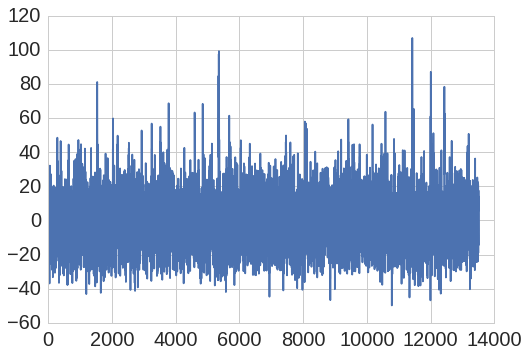

In [184]:
#plt.plot(MP.process_data.runkalman(areaD_s[:,10,10],RQratio=20000,),zorder=10,color='k')
plt.plot(areaD_s[:,22,18])

# Now get Design Matrix

In [185]:
ls '/media/yves/Storage 2/Road_Runner_GP/'

Road_Runner_GP.h5*
search_tones_outDat_2016_2_16_17_38_0.mat*
search_tones_outDat_2016_2_16_17_47_30.mat*
search_tones_outDat_2016_2_16_17_58_33.mat*


In [191]:
import scipy.io as spio
matFilePth = '/media/yves/Storage 2/Road_Runner_GP/search_tones_outDat_2016_2_16_17_38_0.mat'
#matFilePth = '/media/yves/Storage 2/Road_Runner_GP/search_tones_outDat_2016_2_16_17_47_30.mat'

grabI = MP.file_management.load_images.load_GRABinfo(spio.loadmat(matFilePth,struct_as_record=False, squeeze_me=True)['outDat'])

In [192]:
frqs = np.logspace(np.log10(1000),np.log10(80000),num=24)#np.unique(grabI['stimMat'][:,0])
nFreqs = len(frqs)
print nFreqs

24


In [193]:
nFrames = len(grabI['trialOrder'])*45

In [194]:
np.unique(np.round(groupedStims-.5)/2)

array([ -0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.])

In [195]:
#This averages responses to stimuli across levels
groupedStims = np.floor((grabI['trialOrder']-1)/4)

nOccs = [] #number of occurrences
for i in np.unique(groupedStims):
    nOccs.append(np.sum(groupedStims==i))
#assert all(np.array(nOccs)==24), "Something went wrong with your extraction"


In [196]:
nFrames = areaD_s.shape[0]

In [197]:
DM = np.zeros([int(np.max(groupedStims)+1),int(nFrames)])

for stim_type in range(int(np.max(groupedStims).astype('int')+1)):
    stimLocs = np.where(groupedStims==stim_type)[0]
    for loc in stimLocs:
        DM[int(stim_type),int(loc*45)] = 1

In [198]:
resps = np.zeros([areaD_s.shape[1],
                  areaD_s.shape[2],
                  int(np.max(groupedStims)+1),12])

bF = np.linspace(10,0,num=10)
#bF = np.ones(10)
bF /= np.sum(bF)
for idx in range(DM.shape[0]):
    
    DM[idx] = np.convolve(bF,DM[idx],mode='full')[:-(len(bF)-1)]

for stim_type in range(int(np.max(groupedStims).astype('int'))):
    stimLocs = np.where(groupedStims==stim_type)[0]
    for i,idx in enumerate(stimLocs):
        resps[:,:,int(stim_type),i] = np.mean(areaD_s[idx:idx+10]*bF[:,None,None],axis=0)

In [199]:
stimLocs.shape

(12,)

In [200]:
maxs = np.zeros([areaD_s.shape[1]+1,
                areaD_s.shape[2]+1])
alphas = np.zeros([areaD_s.shape[1]+1,
                  areaD_s.shape[2]+1])
for i in range(areaD_s.shape[1]):
    
    for j in range(areaD_s.shape[2]):
        maxs[i,j] = np.argmax(np.mean(np.squeeze(resps[i,j]),axis=1))
        alphas[i,j] = 1 if (np.max(np.mean(np.squeeze(resps[i,j]),axis=1)) -
                            np.mean(np.mean(np.squeeze(resps[i,j]),axis=1)))>.5 else 0
        

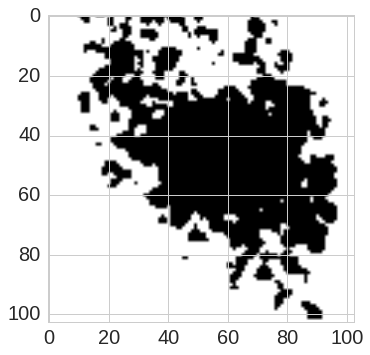

In [201]:
plt.imshow(alphas)

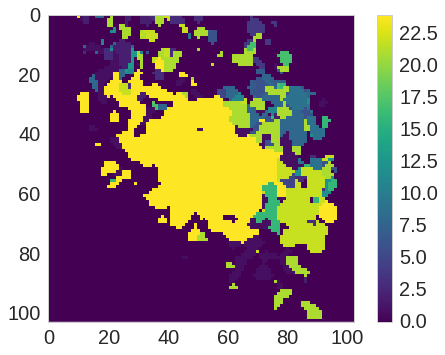

In [203]:
plt.imshow(maxs*alphas,interpolation='None',cmap='viridis')
plt.grid()
plt.colorbar()

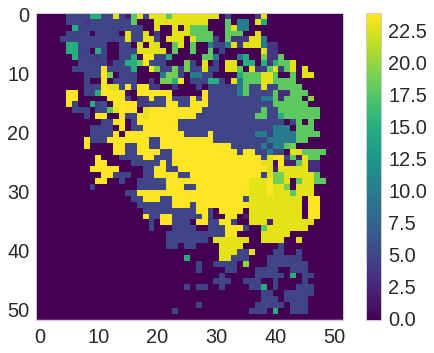

In [156]:
plt.imshow(maxs*alphas,interpolation='None',cmap='viridis')
plt.grid()
plt.colorbar()

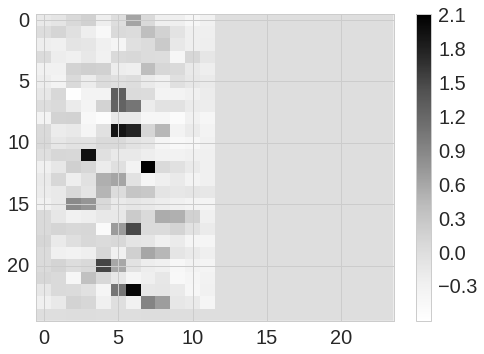

In [39]:
plt.imshow(np.squeeze(resps[20,20]),aspect='auto',interpolation='none')
plt.colorbar()

In [132]:
plt.imshow(np.squeeze(resps[60,60]),aspect='auto',interpolation='none')
plt.colorbar()

IndexError: index 60 is out of bounds for axis 0 with size 51

In [10]:
bF = np.ones(10)
bF /= np.sum(bF)
for idx in range(DM.shape[0]):
    
    DM[idx] = np.convolve(bF,DM[idx],mode='full')[:-(len(bF)-1)]

NameError: name 'DM' is not defined

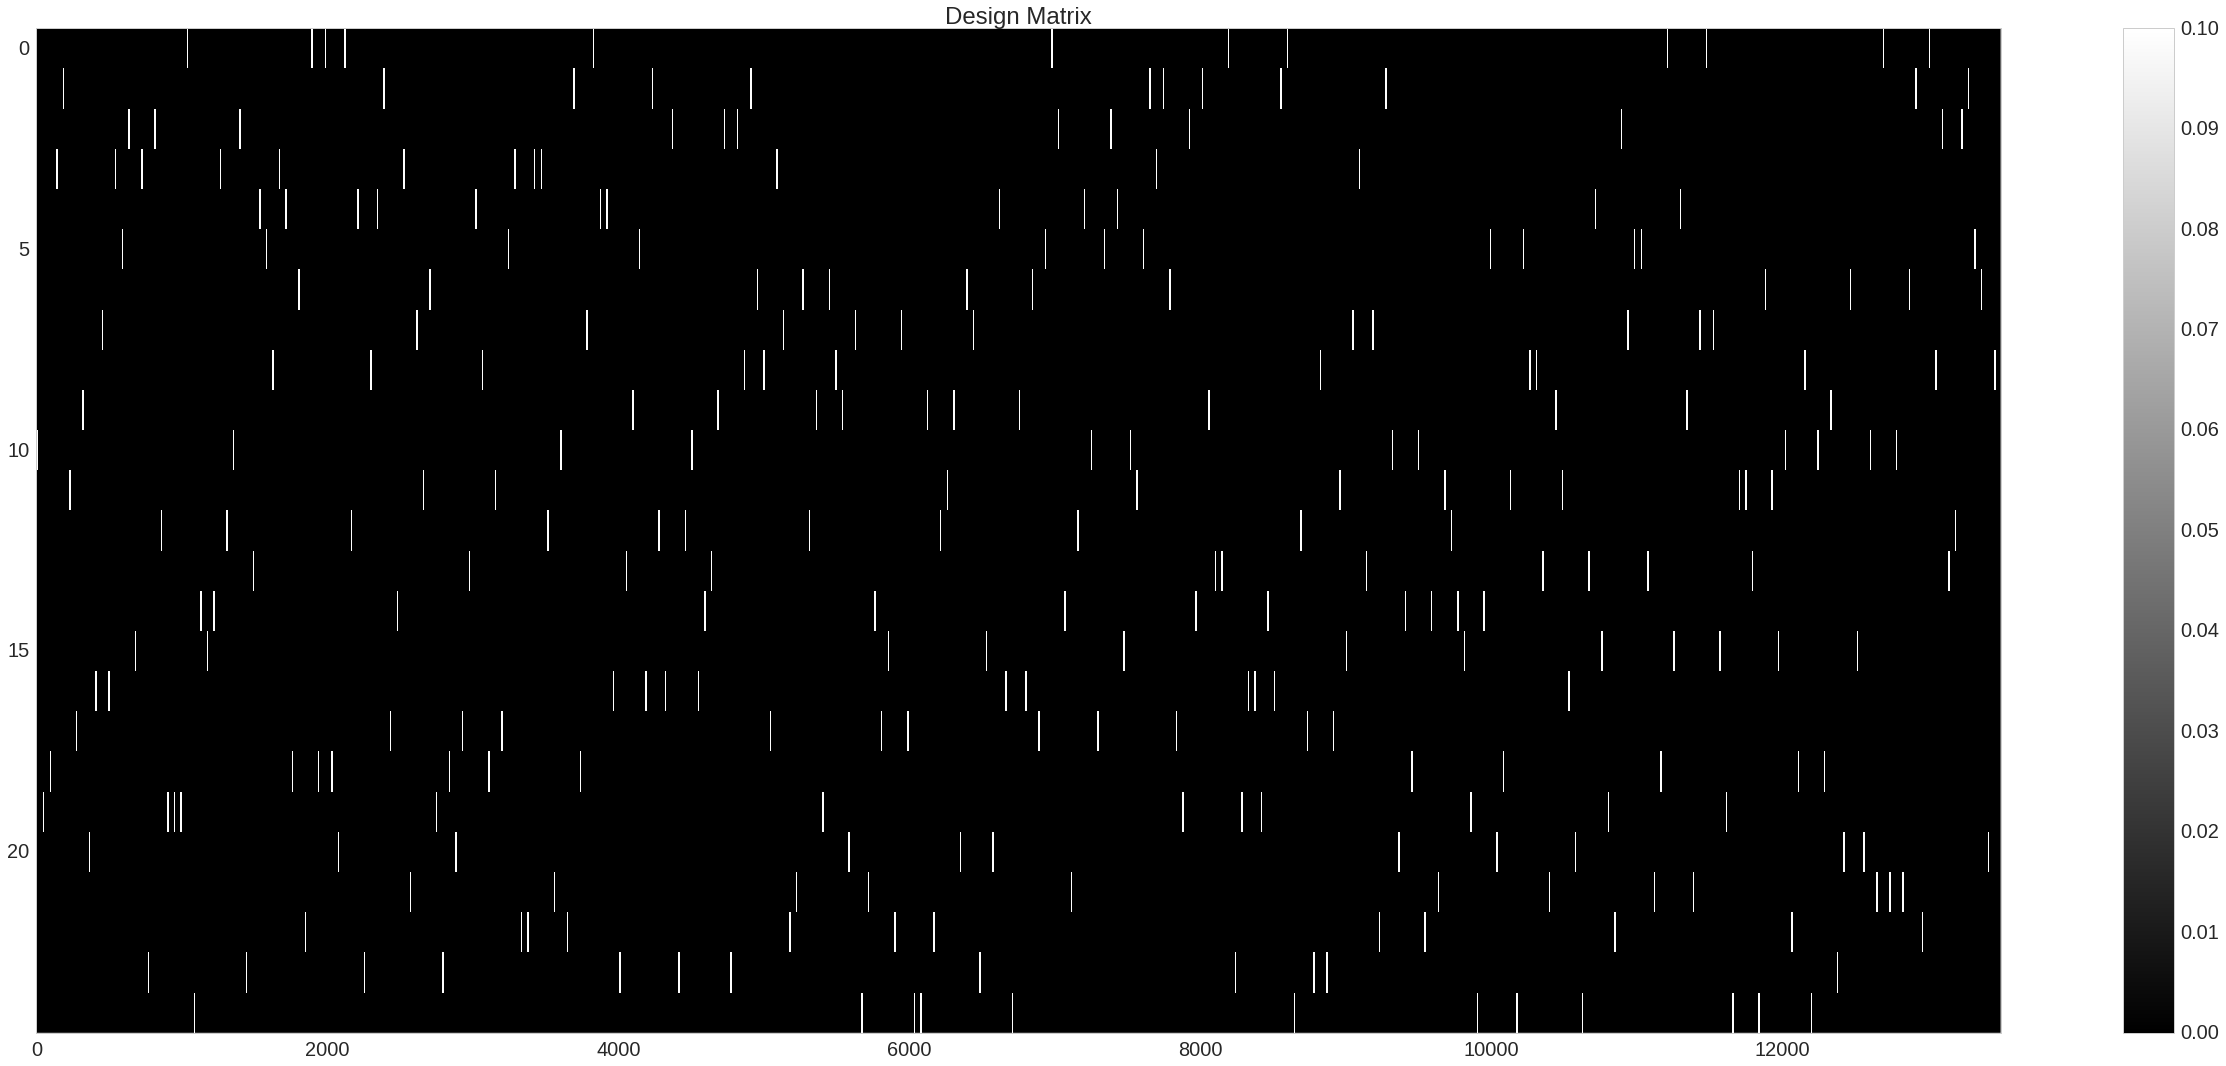

In [40]:
plt.figure(figsize=(44,18))


plt.title('Design Matrix')

plt.imshow(DM,aspect='auto',cmap='binary_r',interpolation='none')
plt.colorbar()
plt.grid()

## From the Design Matrix extract the responses for each neuron at each pixel

# Now fit a population of neurons in a vectorised operation

In [163]:
class population_RFs(object):
    
    """ define a population of neurons for inference of receptive fields using bayesian
        linear regression """
    
    def __init__(self):

        self.neurons = {}

    def add_neuron(self, neuron, neuron_id):
        
        self.neurons[neuron_id] = neuron
        
        

In [164]:
pRF = population_RFs()

In [170]:
for i in range(20):

    resps,x,y,g = sample_neuron(best_resp=i,
                                noiseVar=np.abs(np.random.normal(loc=1,scale=.2,size=1)),
                                sigma=1,
                                nRepeats=5,
                                plot=False,
                                maxA=np.random.randint(1,9,size=1))
    
    
    neuron = {'resps':resps,
              'x': x,
              'y': y,
              'g': g}
    pRF.add_neuron(resps,i)


phi_params = np.linspace(0,13,num=24)
#x_locs = [i[0] for i in resps]
X = project_X(phi_params,x_locs).T

In [215]:
n_neurons = 20
stim_dim = 24
#Here M is an (n_neurons x stim_dimensions) matrix
M = np.random.random(size=(n_neurons,stim_dim))*3

In [229]:
m = M.flatten(order='F')

In [230]:
X[:,0].dot(M[0])

1.9474610391231515

In [231]:
M[0].dot(X[:,0])

1.9474610391231515

In [232]:
#This is the stimulus projection into basis space in a cool way across neurons
Vi = np.kron(X[:,0],np.eye(20))
np.dot(Vi,m)

array([ 1.94746104,  3.55451931,  1.3344038 ,  1.74193933,  1.82143514,
        2.28578246,  2.5915893 ,  1.79514224,  1.06050725,  0.6364206 ,
        1.39033298,  0.44529832,  3.51947042,  2.0677838 ,  2.67488215,
        0.2991695 ,  3.82257285,  2.75607158,  2.10272735,  2.00085598])

In [187]:
#This is the basis projection of the response to one stimulus
print np.kron(X[:,0],np.eye(20))

[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


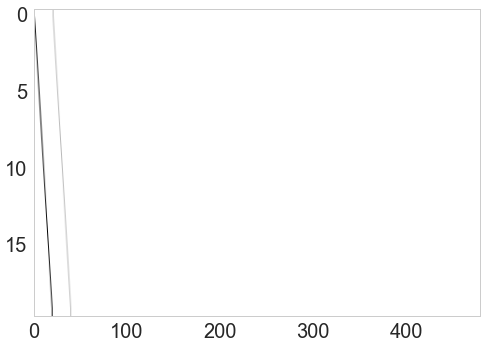

In [189]:
plt.imshow(np.kron(X[:,0],np.eye(20)),aspect='auto')
plt.grid()

In [233]:
a = np.array([[1,2], [3,4]])

In [235]:
print a

[[1 2]
 [3 4]]


In [234]:
a.flatten(order='F')

array([1, 3, 2, 4])

In [208]:
839801

839801

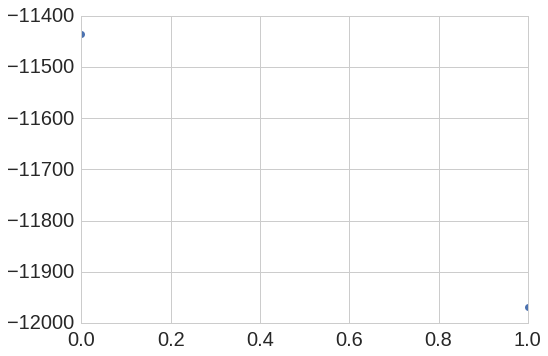

In [205]:
plt.plot([-11436,-11970],'o')
plt.ylabel

In [206]:
np.log(1)

0.0

In [207]:
np.log(0.0001)

-9.2103403719761818

In [39]:
r"s] %d%%" r"s] %d%%" 

's] %d%%s] %d%%'

In [63]:
from time import sleep
import sys

rg = 1350

maxN = 100

pFac = rg/maxN
for i in range(rg):
    sys.stdout.write('\r')
    # the exact output you're looking for:
    pStr = r"[%-100s] %d%%" 
    sys.stdout.write(pStr % ('.'*int(np.round(i/pFac)), 5))
    sys.stdout.flush()
    sleep(0.0001)

[....................................................................................................] 5%

In [64]:
102/13500

0.007555555555555556